# Module 4: NLP and the Pipeline

* DS 5001
* Raf Alvarado

# Overview

We import a collection of texts and convert to F2. Then we annotate the collection to create an F3-level model.

# Set Up

## Configs

In [1]:
OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']
epub_dir = 'epubs'

## Imports

In [2]:
import pandas as pd
import numpy as np
from glob import glob
import re
import nltk

In [3]:
%matplotlib inline

## Import NLTK and download resources

If you need to install NLTK, see the [instructions here](https://www.nltk.org/install.html). You can also install this with Anaconda, like so:

`conda install nltk`

Once you have installed NLTK, you will need to download resources, which will happen when you run the following cell. If the interactive window opens, you may need to set your NLTK Data Directory, as described in the [instructions here](https://www.nltk.org/data.html). To set the directory, click on the File menu and select Change Download Directory. For central installation, set this to `C:\nltk_data` (Windows),`/usr/local/share/nltk_data` (Mac), or `/usr/share/nltk_data` (Unix). 

> If you did not install the data to one of the above central locations, you will need to set the NLTK_DATA environment variable to specify the location of the data. (On a Windows machine, right click on “My Computer” then select Properties > Advanced > Environment Variables > User Variables > New...)

In [4]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('tagsets')

[nltk_data] Downloading package punkt to /Users/rca2t/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/rca2t/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /Users/rca2t/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package tagsets to /Users/rca2t/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


True

# Acquire

Download the novels of Jane Austen and Herman Melville from Project Gutenberg. I actually used a utility I created called PGTK:

* https://github.com/ontoligent-design/pgtk

They are available in the Resources tree in Collab. Or, you can visit the wiki page for today's lab and find the link under "Resources."

# Inspect

Since Project Gutenberg texts vary widely in their markup, we define our chunking patterns by hand.

In [5]:
roman = '[IVXLCM]+'
caps = "[A-Z';, -]+"
chap_pats = {
    158: {
        'start_line': 37,
        'end_line': 16261,
        'volume': re.compile('^\s*VOLUME\s+{}\s*$'.format(roman)),
        'chapter': re.compile('^\s*CHAPTER\s+{}\s*$'.format(roman))
    },
    946: {
        'start_line': 38,
        'end_line': 2556,
        'chapter': re.compile("^\s*{}\s*$".format(roman))
    },
    1212: {
        'start_line': 77,
        'end_line': 3432,
        'chapter': re.compile("^\s*LETTER .* to .*$")
    },
    141: {\
        'start_line': 40,
        'end_line': 15376,
        'chapter': re.compile("^CHAPTER\s+{}$".format(roman))
    },
    121: {
        'start_line': 57,
        'end_line': 7874,
        'chapter': re.compile("^CHAPTER\s+\d+$")
    },
    105: {
        'start_line': 48,
        'end_line': 8360,
        'chapter': re.compile("^Chapter\s+\d+$")
    },
    1342: {
        'start_line': 37,
        'end_line': 13061,
        'chapter': re.compile("^Chapter\s+\d+$")
    },
    161: {
        'start_line': 43,
        'end_line': 12654,
        'chapter': re.compile("^CHAPTER\s+\d+$")          
    },
    15422: {
        'start_line': 193,
        'end_line': 7501,
        'chapter': re.compile("^\s*CHAPTER\s+{}\.".format(roman))
    },
    13720: {
        'start_line': 187,
        'end_line': 11470,
        'chapter': re.compile("^\s*CHAPTER\s+{}\s*$".format(roman))
    },
    13721: {
        'start_line': 164,
        'end_line': 13135,
        'chapter': re.compile("^\s*CHAPTER\s+{}\s*$".format(roman))
    },
    2701: {
        'start_line': 52,
        'end_line': 21743,
        'chapter': re.compile("^(ETYMOLOGY|EXTRACTS|CHAPTER)")
    },
    4045: {
        'start_line': 138,
        'end_line': 11655,
        'volume': re.compile("^\s*PART\s+{}\s*$".format(roman)),
        'chapter': re.compile("^\s*CHAPTER\s+{}\.\s*$".format(roman))
    },
    34970: {
        'start_line': 234,
        'end_line': 16267,
        'volume': re.compile("^\s*BOOK\s+{}\.\s*$".format(roman)),
        'chapter': re.compile("^\s*{}\.\s*$".format(roman))
    },
    8118: {
        'start_line': 142,
        'end_line': 12300,
        'chapter': re.compile("^\s*{}\. .*$".format(roman))
    },
    53861: {
        'start_line': 129,
        'end_line': 6904,
        'chapter': re.compile('^\s*{}\s*$'.format(caps))
    },
    21816: {
        'start_line': 309,
        'end_line': 11023,
        'chapter': re.compile('^CHAPTER\s+{}\.?$'.format(roman))
    },
    15859: {
        'start_line': 77,
        'end_line': 8619,
        'chapter': re.compile('^\s*{}\s*$'.format(caps))
    },
    1900: {
        'start_line': 43,
        'end_line': 11216,
        'chapter': re.compile("^CHAPTER\s+\w+\s*$")
    },
    10712: {
        'start_line': 205,
        'end_line': 15487,
        'chapter': re.compile("^CHAPTER\s+{}\.\s*$".format(roman))
    }
}

# Register and Chunk

In [338]:
def acquire_epubs(epub_list, chap_pats, OHCO=OHCO):
    
    my_lib = []
    my_doc = []

    for epub_file in epub_list:
        
        # Get PG ID from filename
        book_id = int(epub_file.split('-')[-1].split('.')[0].replace('pg',''))
        print("BOOK ID", book_id)
        
        # Import file as lines
        lines = open(epub_file, 'r', encoding='utf-8-sig').readlines()
        df = pd.DataFrame(lines, columns=['line_str'])
        df.index.name = 'line_num'
        df.line_str = df.line_str.str.strip()
        df['book_id'] = book_id
        
        # FIX CHARACTERS TO IMPROVE TOKENIZATION
        df.line_str = df.line_str.str.replace('—', ' — ')
        df.line_str = df.line_str.str.replace('-', ' - ')
        
        # Get book title and put into LIB table -- note problems, though
        book_title = re.sub(r"The Project Gutenberg eBook( of|,) ", "", df.loc[0].line_str, flags=re.IGNORECASE)
        book_title = re.sub(r"Project Gutenberg's ", "", book_title, flags=re.IGNORECASE)
        
        # Remove cruft
        a = chap_pats[book_id]['start_line'] - 1
        b = chap_pats[book_id]['end_line'] + 1
        df = df.iloc[a:b]
        
        # Chunk by chapter
        chap_lines = df.line_str.str.match(chap_pats[book_id]['chapter'])
        chap_nums = [i+1 for i in range(df.loc[chap_lines].shape[0])]
        df.loc[chap_lines, 'chap_num'] = chap_nums
        df.chap_num = df.chap_num.ffill()

        # Clean up
        df = df[~df.chap_num.isna()] # Remove chapter heading lines
        df = df.loc[~chap_lines] # Remove everything before Chapter 1
        df['chap_num'] = df['chap_num'].astype('int')
        
        # Group -- Note that we exclude the book level in the OHCO at this point
        df = df.groupby(OHCO[1:2]).line_str.apply(lambda x: '\n'.join(x)).to_frame() # Make big string
        
        # Split into paragrpahs
        df = df['line_str'].str.split(r'\n\n+', expand=True).stack().to_frame().rename(columns={0:'para_str'})
        df.index.names = OHCO[1:3] # MAY NOT BE NECESSARY UNTIL THE END
        df['para_str'] = df['para_str'].str.replace(r'\n', ' ').str.strip()
        df = df[~df['para_str'].str.match(r'^\s*$')] # Remove empty paragraphs
        
        # Set index
        df['book_id'] = book_id
        df = df.reset_index().set_index(OHCO[:3])

        # Register
        my_lib.append((book_id, book_title, epub_file))
        my_doc.append(df)

    docs = pd.concat(my_doc)
    library = pd.DataFrame(my_lib, columns=['book_id', 'book_title', 'book_file']).set_index('book_id')
    print("Done.")
    return library, docs

In [339]:
epubs = [epub for epub in sorted(glob(epub_dir+'/*.txt'))]
LIB, DOC = acquire_epubs(epubs, chap_pats)

BOOK ID 158
BOOK ID 946
BOOK ID 1212
BOOK ID 141
BOOK ID 121
BOOK ID 105
BOOK ID 1342
BOOK ID 161
BOOK ID 15422
BOOK ID 13720
BOOK ID 13721
BOOK ID 2701
BOOK ID 4045
BOOK ID 34970
BOOK ID 8118
BOOK ID 53861
BOOK ID 21816
BOOK ID 15859
BOOK ID 1900
BOOK ID 10712
Done.


In [340]:
LIB

,book_title,book_file
book_id,,
158,"Emma, by Jane Austen",epubs/AUSTEN_JANE_EMMA-pg158.txt
946,"Lady Susan, by Jane Austen",epubs/AUSTEN_JANE_LADY_SUSAN-pg946.txt
1212,"Love And Freindship And Other Early Works, by ...",epubs/AUSTEN_JANE_LOVE_AND_FREINDSHIP_SIC_-pg1...
141,"Mansfield Park, by Jane Austen",epubs/AUSTEN_JANE_MANSFIELD_PARK-pg141.txt
121,"Northanger Abbey, by Jane Austen",epubs/AUSTEN_JANE_NORTHANGER_ABBEY-pg121.txt
105,"Persuasion, by Jane Austen",epubs/AUSTEN_JANE_PERSUASION-pg105.txt
1342,"Pride and Prejudice, by Jane Austen",epubs/AUSTEN_JANE_PRIDE_AND_PREJUDICE-pg1342.txt
161,"Sense and Sensibility, by Jane Austen",epubs/AUSTEN_JANE_SENSE_AND_SENSIBILITY-pg161.txt
15422,"Israel Potter, by Herman Melville",epubs/MELVILLE_HERMAN_ISRAEL_POTTER_HIS_FIFTY_...


In [341]:
DOC.sample(10)

,,,para_str
book_id,chap_num,para_num,
1212,15,7,"""By no means, (said he) for what may be pretty..."
121,16,10,"""Well, I shall see how they behave to me this ..."
10712,89,25,But notwithstanding the iniquities of a man - ...
2701,92,5,II. A Loose - Fish is fair game for anybody wh...
10712,16,13,By candidly confessing my feelings on this sub...
161,13,26,"""I wish it could be so easily settled. But it..."
2701,35,9,Now the various species of whales need some so...
141,43,9,Poor Susan was very little better fitted for h...
105,14,6,"Charles laughed again and said, ""Now Mary, you..."


# Tokenize and Annotate

We use NLTK this time. Note that this process takes some time, mainly because the NLTK functions are not optimized for dataframes.

Note that we can choose between tokenizers. NLTK offers a variety of them. Here is a list.

In [314]:
def tokenize(doc_df, OHCO=OHCO, remove_pos_tuple=False, ws=False):
    
    # Paragraphs to Sentences
    df = doc_df.para_str\
        .apply(lambda x: pd.Series(nltk.sent_tokenize(x)))\
        .stack()\
        .to_frame()\
        .rename(columns={0:'sent_str'})
    
    # Sentences to Tokens
    # Local function to pick tokenizer
    def word_tokenize(x):
        if ws:
            s = pd.Series(nltk.pos_tag(nltk.WhitespaceTokenizer().tokenize(x)))
        else:
            s = pd.Series(nltk.pos_tag(nltk.word_tokenize(x))) # Discards stuff in between
        return s
            
    df = df.sent_str\
        .apply(word_tokenize)\
        .stack()\
        .to_frame()\
        .rename(columns={0:'pos_tuple'})
    
    # Grab info from tuple
    df['pos'] = df.pos_tuple.apply(lambda x: x[1])
    df['token_str'] = df.pos_tuple.apply(lambda x: x[0])
    if remove_pos_tuple:
        df = df.drop('pos_tuple', 1)
    
    # Add index
    df.index.names = OHCO
    
    return df

In [315]:
%%time
TOKEN = tokenize(DOC, ws=False)

CPU times: user 2min 50s, sys: 6.04 s, total: 2min 56s
Wall time: 2min 57s


In [342]:
TOKEN.head()

pos_tuple  pos  \
book_id chap_num para_num sent_num token_num                          
158     1        1        0        0               (Emma, NNP)  NNP   
                                   1          (Woodhouse, NNP)  NNP   
                                   2                    (,, ,)    ,   
                                   3            (handsome, NN)   NN   
                                   4                    (,, ,)    ,   

                                              token_str   term_str  
book_id chap_num para_num sent_num token_num                        
158     1        1        0        0               Emma       emma  
                                   1          Woodhouse  woodhouse  
                                   2                  ,             
                                   3           handsome   handsome  
                                   4                  ,

In [317]:
TOKEN[TOKEN.pos.str.match('^NNP')]

pos_tuple  pos  token_str
book_id chap_num para_num sent_num token_num                                  
158     1        1        0        0               (Emma, NNP)  NNP       Emma
                                   1          (Woodhouse, NNP)  NNP  Woodhouse
                 3        0        3               (Miss, NNP)  NNP       Miss
                                   4             (Taylor, NNP)  NNP     Taylor
                                   7                (Mr., NNP)  NNP        Mr.
...                                                        ...  ...        ...
10712   92       22       7        1               (Lord, NNP)  NNP       Lord
                                   2               (High, NNP)  NNP       High
                                   3            (Admiral, NNP)  NNP    Admiral
                 23       0        0            (Whoever, NNP)  NNP    Whoever
                                   7               (Life, NNP)  NNP       Life

[90404 rows x 3 columns]

# Reduce

Extract a vocabulary from the TOKEN table

In [318]:
TOKEN['term_str'] = TOKEN['token_str'].str.lower().str.replace('[\W_]', '')

In [344]:
VOCAB = TOKEN.term_str.value_counts().to_frame()\
    .rename(columns={'index':'term_str', 'term_str':'n'})\
    .sort_index().reset_index().rename(columns={'index':'term_str'})
VOCAB.index.name = 'term_id'

In [345]:
VOCAB['num'] = VOCAB.term_str.str.match("\d+").astype('int')

In [348]:
VOCAB.head()

,term_str,n,num
term_id,,,
0,,412917,0
1,0,2,1
2,1,18,1
3,10,6,1
4,100,2,1


# Annotate (VOCAB)

## Add Stopwords

We use NLTK's built in stopword list for English. Note that we can add and subtract from this list, or just create our own list and keep it in our data model.

In [322]:
sw = pd.DataFrame(nltk.corpus.stopwords.words('english'), columns=['term_str'])
sw = sw.reset_index().set_index('term_str')
sw.columns = ['dummy']
sw.dummy = 1

In [323]:
sw.sample(10)

,dummy
term_str,
yourself,1
during,1
between,1
few,1
be,1
needn,1
isn't,1
doesn,1
she,1


In [324]:
VOCAB['stop'] = VOCAB.term_str.map(sw.dummy)
VOCAB['stop'] = VOCAB['stop'].fillna(0).astype('int')

In [325]:
VOCAB[VOCAB.stop == 1].sample(10)

,term_str,n,num,stop
term_id,,,,
30041,same,1468,0,1
10550,doing,357,0,1
34795,then,3882,0,1
16511,hers,132,0,1
24540,own,2842,0,1
21004,ma,3,0,1
38029,very,6292,0,1
19009,itself,513,0,1
38907,where,1953,0,1


## Add Stems

In [349]:
from nltk.stem.porter import PorterStemmer
stemmer1 = PorterStemmer()
VOCAB['stem_porter'] = VOCAB.term_str.apply(stemmer1.stem)

from nltk.stem.snowball import SnowballStemmer
stemmer2 = SnowballStemmer("english")
VOCAB['stem_snowball'] = VOCAB.term_str.apply(stemmer2.stem)

from nltk.stem.lancaster import LancasterStemmer
stemmer3 = LancasterStemmer()
VOCAB['stem_lancaster'] = VOCAB.term_str.apply(stemmer3.stem)

In [350]:
VOCAB.sample(10)

,term_str,n,num,stem_porter,stem_snowball,stem_lancaster
term_id,,,,,,
29672,rotation,11,0,rotat,rotat,rot
5321,cars,3,0,car,car,car
3058,beaching,2,0,beach,beach,beach
23043,nails,28,0,nail,nail,nail
3234,beginningly,1,0,beginningli,begin,begin
32971,staving,2,0,stave,stave,stav
38651,watered,8,0,water,water,wat
47,1695,1,1,1695,1695,1695
12359,ewer,3,0,ewer,ewer,ew


In [352]:
VOCAB[VOCAB.stem_porter != VOCAB.stem_snowball]

,term_str,n,num,stem_porter,stem_snowball,stem_lancaster
term_id,,,,,,
208,abandonedly,2,0,abandonedli,abandon,abandon
256,abhorringly,1,0,abhorringli,abhor,abhor
267,abjectly,2,0,abjectli,abject,abject
269,abjectus,1,0,abjectu,abjectus,abject
303,aboundingly,1,0,aboundingli,abound,abound
...,...,...,...,...,...,...
39633,yes,962,0,ye,yes,ye
39682,yrs,4,0,yr,yrs,yr
39685,zaccheus,1,0,zaccheu,zaccheus,zacche


# Save

In [353]:
DOC.to_csv('DOC.csv')
LIB.to_csv('LIB.csv')
VOCAB.to_csv('VOCAB.csv')
TOKEN.to_csv('TOKEN.csv')

# Save to SQLite

In [354]:
import sqlite3

TOKEN2 = TOKEN.drop('pos_tuple', 1)

with sqlite3.connect('mod4-corpus.db') as db:
    DOC.to_sql('doc', db, index=True, if_exists='replace')
    LIB.to_sql('lib', db, index=True, if_exists='replace')
    VOCAB.to_sql('vocab', db, index=True, if_exists='replace')
    TOKEN2.to_sql('token', db, index=True, if_exists='replace')

# Appendix: Explore NER tagging

This takes a while, so we look at one book only.

In [331]:
%%time 
NER = TOKEN.loc[158].groupby(OHCO[1:4]).pos_tuple\
    .apply(lambda x: nltk.ne_chunk(x.tolist()))\
    .to_frame().rename(columns={'pos_tuple':'nltk_sentence'})

CPU times: user 46.2 s, sys: 156 ms, total: 46.3 s
Wall time: 46.4 s


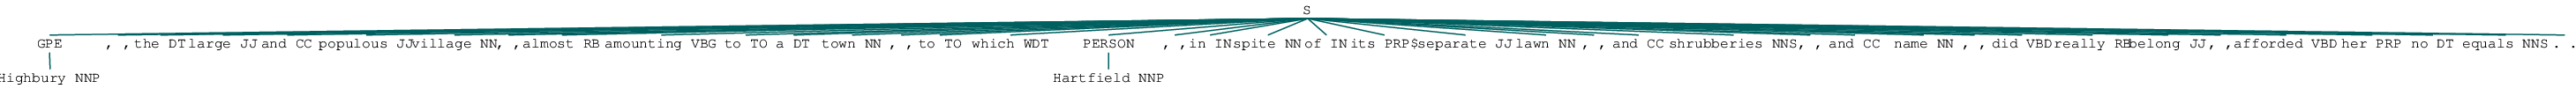

In [332]:
NER.iloc[26].nltk_sentence

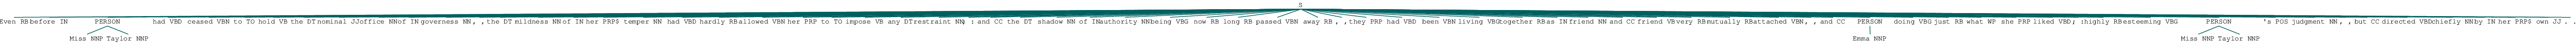

In [333]:
NER.iloc[5].nltk_sentence

In [334]:
NER['len'] = NER.nltk_sentence.apply(lambda x: len(x))

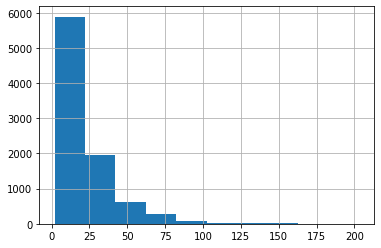

In [336]:
NER.len.hist();

In [337]:
NER[NER.len == 10].iloc[0].tolist()

[Tree('S', [Tree('PERSON', [('Between', 'NNP')]), ('_them_', 'VBD'), ('it', 'PRP'), ('was', 'VBD'), ('more', 'RBR'), ('the', 'DT'), ('intimacy', 'NN'), ('of', 'IN'), ('sisters', 'NNS'), ('.', '.')]),
 10]

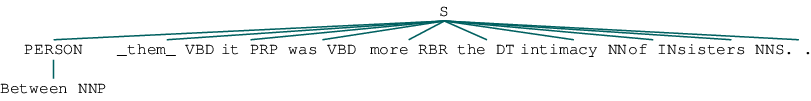

In [307]:
NER[NER.len == 10].iloc[0].nltk_sentence

In [116]:
NER[NER.len == 10].iloc[1].tolist()

[Tree('S', [('It', 'PRP'), ('was', 'VBD'), Tree('PERSON', [('Miss', 'NNP'), ('Taylor', 'NNP')]), ("'s", 'POS'), ('loss', 'NN'), ('which', 'WDT'), ('first', 'RB'), ('brought', 'VBD'), ('grief', 'NN'), ('.', '.')]),
 10]

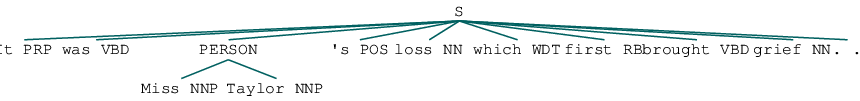

In [308]:
NER[NER.len == 10].iloc[1].nltk_sentence

In [313]:
NER[NER.len == 10].iloc[2].to_list()

[Tree('S', [('We', 'PRP'), ('talked', 'VBD'), ('it', 'PRP'), ('all', 'DT'), ('over', 'IN'), ('with', 'IN'), Tree('PERSON', [('Mr.', 'NNP'), ('Weston', 'NNP')]), ('last', 'JJ'), ('night', 'NN'), ('.', '.')]),
 10]

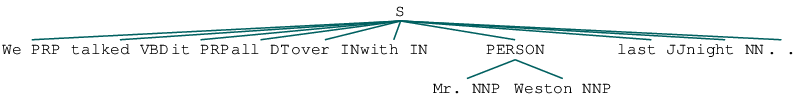

In [309]:
NER[NER.len == 10].iloc[2].nltk_sentence

# POS Tagset

This a token-level feature -- not a vocab feature

In [355]:
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or